<a href="https://colab.research.google.com/github/glwtr22/paper_review_code/blob/main/ASPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


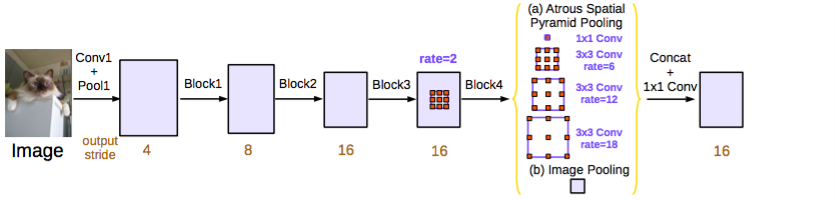

In [ ]:
from IPython.display import Image
Image('/gdrive/My Drive/ASPP.png')

In [ ]:

#코드는 Yude Wang님 깃허브에서 가져왔습니다.

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from net.sync_batchnorm import SynchronizedBatchNorm2d

class ASPP(nn.Module):
	
	def __init__(self, dim_in, dim_out, rate=1, bn_mom=0.1):
		super(ASPP, self).__init__()
		self.branch1 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 1, 1, padding=0, dilation=rate,bias=True),
				SynchronizedBatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),
		)
		self.branch2 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=6*rate, dilation=6*rate,bias=True),
				SynchronizedBatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch3 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=12*rate, dilation=12*rate,bias=True),
				SynchronizedBatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch4 = nn.Sequential(
				nn.Conv2d(dim_in, dim_out, 3, 1, padding=18*rate, dilation=18*rate,bias=True),
				SynchronizedBatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),	
		)
		self.branch5_conv = nn.Conv2d(dim_in, dim_out, 1, 1, 0,bias=True)
		self.branch5_bn = SynchronizedBatchNorm2d(dim_out, momentum=bn_mom)
		self.branch5_relu = nn.ReLU(inplace=True)
		self.conv_cat = nn.Sequential(
				nn.Conv2d(dim_out*5, dim_out, 1, 1, padding=0,bias=True),
				SynchronizedBatchNorm2d(dim_out, momentum=bn_mom),
				nn.ReLU(inplace=True),		
		)
#		self.conv_cat = nn.Sequential(
#				nn.Conv2d(dim_out*4, dim_out, 1, 1, padding=0),
#				SynchronizedBatchNorm2d(dim_out),
#				nn.ReLU(inplace=True),		
#		)
	def forward(self, x):
		[b,c,row,col] = x.size()
		conv1x1 = self.branch1(x)
		conv3x3_1 = self.branch2(x)
		conv3x3_2 = self.branch3(x)
		conv3x3_3 = self.branch4(x)
		global_feature = torch.mean(x,2,True)
		global_feature = torch.mean(global_feature,3,True)
		global_feature = self.branch5_conv(global_feature)
		global_feature = self.branch5_bn(global_feature)
		global_feature = self.branch5_relu(global_feature)
		global_feature = F.interpolate(global_feature, (row,col), None, 'bilinear', True)
		
		feature_cat = torch.cat([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3, global_feature], dim=1)
#		feature_cat = torch.cat([conv1x1, conv3x3_1, conv3x3_2, conv3x3_3], dim=1)
		result = self.conv_cat(feature_cat)
		return result